# Phase Slope Index method: Examples

### Purpose
This is a walk-through notebook on *Robustly Estimating the Flow Direction of Information in Complex Physical Systems* paper, by *Guido Nolte, Andreas Ziehe, Vadim V. Nikulin, Alois Schlögl, Nicole Krämer, Tom Brismar, and Klaus-Robert Müller*, implemented in Julia-Language (please see http://doc.ml.tu-berlin.de/causality/ and [Nolte et al. 2008](http://link.aps.org/abstract/PRL/v100/e234101)).


### Acknowledgement
This work was funded by the German Federal Ministry of Education and Research ([BMBF](https://www.bmbf.de/)) in the project ALICE III under grant ref. 01IS18049B.

### Load packages

In [1]:
using PhaseSlopeIndex
using Plots: plot, heatmap, cgrad
using DSP: blackman

### Data
`mixed_data` contains four channels, where:
- channels 1 and 2 are i.i.d. uniform ``[0, 1]`` noise
- channel 3 is delayed (by 1 sample) channel 1
- channel 4 is delayed (by 16 samples) channel 1 plus i.i.d. uniform ``[0, 0.2]`` noise

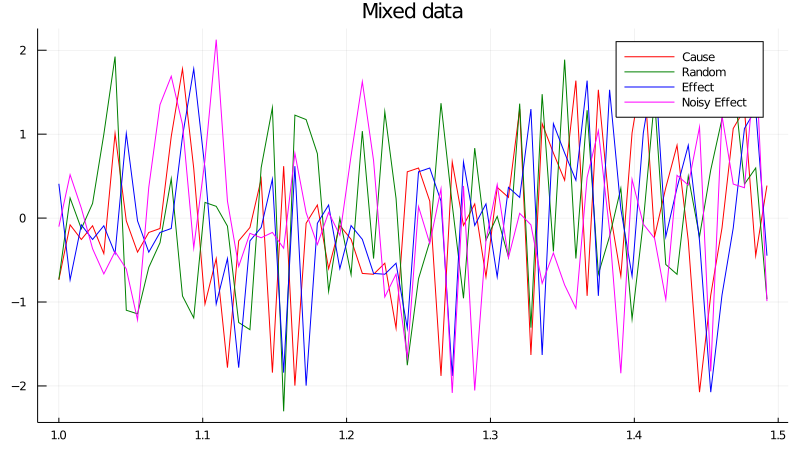

In [2]:
# data generation
T = Float64
n_channels = 4  # number of channels
n_samples = 2^16  # number of data points measured in each channel
fs = 128  # sampling frequency
time_array = Array{T}(range(1; step=1 / fs, length=n_samples))

# mixed data
range_c4 = 1:n_samples
range_c1 = range_c4 .+ 16
range_c3 = range_c1 .- 1

rand_data = randn(T, (n_samples + 16, 1)) # uniform noise
cause_source = rand_data[range_c1]  # channel 1
random_source = randn(T, n_samples)  # channel 2, uniform noise
effect_source = rand_data[range_c3]  # channel 3
weak_effect = rand_data[range_c4] .- (randn(T, (n_samples, 1)) / 5) # channel 4
mixed_data = hcat(cause_source, random_source, effect_source, weak_effect)

p1 = plot(
    time_array[1:64],
    mixed_data[1:64, :];
    title="Mixed data",
    label=["Cause" "Random" "Effect" "Noisy Effect"],
    linecolor=["red" "green" "blue" "magenta"],
)

plot(p1; layout=(1, 1), size=(800, 450))

### PSI

In [3]:
@doc data2psi

```
data2psi(data, seglen [, segshift, eplen, freqlist, method,
                         nboot, segave, subave, detrend])
```

calculates phase slope index (PSI)

### Arguments

  * `data::AbstractArray`: NxM array for N data points in M channels
  * `seglen::Integer`: segment length (determines the frequency resolution)

*optional arguments*

  * `segshift::Integer`: number of bins by which neighboring segments are shifted (default=seglen/2)
  * `eplen::Integer`: length of epochs (if eplen=0, eplen is defaulted to number of samples)
  * `freqlist::AbstractArray`: 2D Array where each column is a frequency band (default is full range)
  * `method::String`: standard deviation estimation method (default is "jackknife")
  * `subave::Bool`: if true, subtract average across CS segments (default is false)
  * `segave::Bool`: if true, average across CS segments (default is true)
  * `nboot::Integer`: number of bootstrap resamplings (default is 100)
  * `detrend::Bool`: if true, performs a 0th-order detrend across raw segments (default is false)
  * `window::Function`: window function with interval length as sole necessary argument (default is Hanning)
  * `verbose::Bool`: if true, warnings and info logs would be echoed. (default is false)

### Returns

  * `psi::AbstractArray`: Phase Slope Index with shape (channel, channel, frequency bands)
  * `psi_std::AbstractArray`: PSI estimated standard deviation with shape (channel, channel, frequency bands)


## Example 1
PSI is calculated over all frequencies for segmented (`seglen = 100`) but continuous data (single epoch, `nep = 1`) and estimation of error using Bootstrap method for 256 resampling iterations (`nboot=256`). The default window function ([Hanning window](https://en.wikipedia.org/wiki/Hann_function)) is used.

┌ Warning: Epoch length = 0 => No estimation of standard deviation.
└ @ PhaseSlopeIndex /home/runner/work/PhaseSlopeIndex.jl/PhaseSlopeIndex.jl/src/PhaseSlopeIndex.jl:128


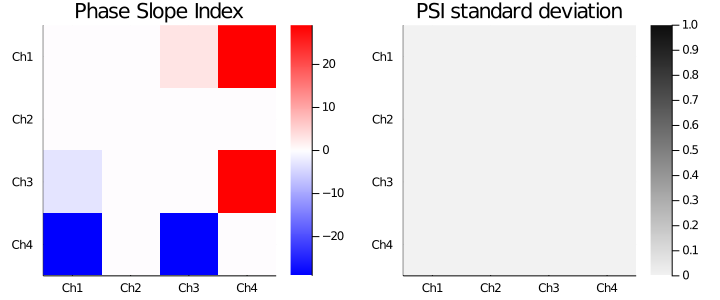

In [4]:
seglen = 100  # segment length
nboot = 256  # number of bootstrap iterations
method = "bootstrap"  # standard deviation estimation method

psi, psi_std = data2psi(mixed_data, seglen; nboot=nboot, method=method)

p1 = heatmap(
    psi;
    ticks=false,
    yflip=true,
    yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    color=cgrad(:bwr),
    title="Phase Slope Index",
)

p2 = heatmap(
    replace!(psi_std, NaN => 0);
    ticks=false,
    yflip=true,
    yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    color=cgrad(:grays; rev=true),
    title="PSI standard deviation",
)

plot(p1, p2; layout=(1, 2), size=(720, 300))

## Example 2
PSI is calculated over 3 frequency bands, for partitioned data to segments (`seglen = 100`) and epochs (`eplen = 200`), estimation of error using [Jackknife method](https://en.wikipedia.org/wiki/Jackknife_resampling) (default). The window function is set to `blackman` (imported from [DSP.jl](https://github.com/JuliaDSP/DSP.jl)). The plots are for only one of the frequency ranges.

We normalize the PSI by dividing it by estimated standard deviation.

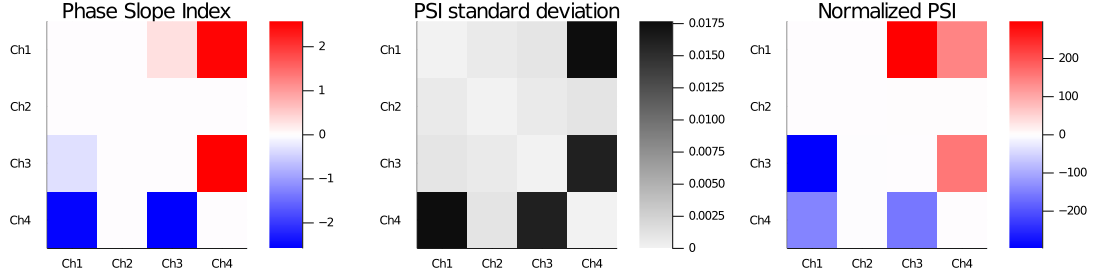

In [5]:
seglen = 100  # segment length
eplen = 200  # epoch length
method = "jackknife"  # standard deviation estimation method

# three frequency bands
freqlist = [[5:1:10;] [6:1:11;] [7:1:12;]]

segave = true  # average across CS segments
subave = true  # subtract average across CS segments
detrend = true  # performs a 0th-order detrend across raw segments
window = blackman  # blackman window function

psi, psi_std = data2psi(
    mixed_data,
    seglen;
    subave=subave,
    segave=segave,
    detrend=detrend,
    freqlist=freqlist,
    eplen=eplen,
    method=method,
    window=blackman,
)

psi_normed = psi ./ (psi_std .+ eps())

p1 = heatmap(
    psi[:, :, 1];
    ticks=false,
    yflip=true,
    yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    color=cgrad(:bwr),
    title="Phase Slope Index",
)

p2 = heatmap(
    psi_std[:, :, 1];
    ticks=false,
    yflip=true,
    yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    color=cgrad(:grays; rev=true),
    title="PSI standard deviation",
)

p3 = heatmap(
    psi_normed[:, :, 1];
    ticks=false,
    yflip=true,
    yticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    xticks=([1, 2, 3, 4], ["Ch1", "Ch2", "Ch3", "Ch4"]),
    color=cgrad(:bwr),
    title="Normalized PSI",
)

plot(p1, p2, p3; layout=(1, 3), size=(1110, 270))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*